In [ ]:
# This notebook aims to demonstrate the use of petlink32 and interfile,
# in creating a sinogram from listmode data.

In [162]:
import petlink32
import interfile

import os
import numpy as np
import matplotlib.pyplot as plt

In [204]:
phantom_data = r"C:/Users/petct/Desktop/Hugo/data/kex/phantom_data"
phantom_path = phantom_data + "/Cylinder/gate01"
# phantom_path = phantom_data + "/kanyl/gate01" 
filenames = []
with os.scandir(phantom_path) as it:
    for entry in it:
        if entry.is_file():
            print("file name {} =".format(len(filenames)), entry.name)
            filenames.append(entry.name)

file name 0 = CylinderPET-LM-01-sino-0.s
file name 1 = CylinderPET-LM-01-sino-0.s.hdr
file name 2 = CylinderPET-LM-01-sino.mhdr
file name 3 = CylinderPET-LM-01.hdr
file name 4 = CylinderPET-LM-01.l


In [205]:
with open("/".join([phantom_path, filenames[4]]), 'rb') as file:
    listmode_packets = np.fromfile(file, dtype = np.uint32)
is_event = petlink32.EVENT.compare(listmode_packets)
events = listmode_packets[is_event]
bin_addresses = petlink32.BIN_ADDRESS.evaluate(events)
print("bin addresses =", bin_addresses)

bin addresses = [287240676 136741771  10685398 ... 164083393  57297369  95300173]


In [206]:
# extract relevant header info
sinogram_HDR_info = interfile.load("/".join([phantom_path, filenames[1]]))
histogram_shape = []
histogram_labels = []
for key, field in sinogram_HDR_info.items():
    if key.startswith('matrix'):
        #print(key, field['value'])
        if key.startswith('matrix size'):
            histogram_shape.append(field['value'])
        else:
            histogram_labels.append(field['value'])
TOF_size = sinogram_HDR_info['number of TOF time bins']['value']
histogram_labels.append('time of flight bins')
histogram_shape.append(TOF_size+1) #+1 for randoms
print("histogram shape =", histogram_shape)
print("histogram labels =", histogram_labels)
histogram_labels[2] = "michelogram bins"
print("alternative histogram labels =", histogram_labels)

histogram shape = [400, 168, 621, 14]
histogram labels = ['sinogram projections', 'sinogram views', 'number of sinograms', 'time of flight bins']
alternative histogram labels = ['sinogram projections', 'sinogram views', 'michelogram bins', 'time of flight bins']


In [207]:
# accumulate events in histogram
histogram_1D = np.zeros(np.prod(histogram_shape), dtype=np.uint16)
np.add.at(histogram_1D, bin_addresses, 1)

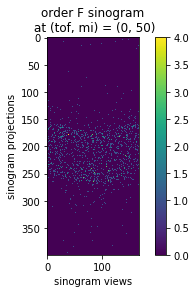

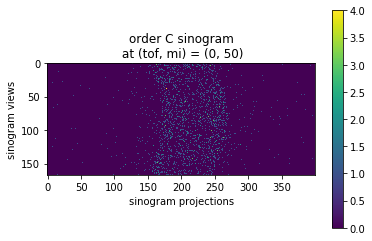

In [208]:
# different options for histogram representation, C or F
for order in ['F', 'C']:
    shape = histogram_shape
    labels = histogram_labels
    if order == 'C':
        shape = np.flip(shape)
        labels = np.flip(labels)
    volume = np.reshape(histogram_1D, shape, order=order)
    mi = 50
    tof = 0
    if order == 'F':
        plt.imshow(volume[:,:, mi, tof])
        plt.xlabel(labels[1])
        plt.ylabel(labels[0])
    else:
        plt.imshow(volume[tof, mi])
        plt.xlabel(labels[3])
        plt.ylabel(labels[2])
    plt.colorbar()
    plt.title("order {} sinogram\n at (tof, mi) = {}".format(order, (tof,mi)))
    plt.show()

In [209]:
# alternatively, add events in 4D
# here using C order
bin_address_4D = np.unravel_index(bin_addresses, shape)
for label, bin_component in zip(labels, bin_address_4D):
    print(label, bin_component)

time of flight bins [6 3 0 ... 3 1 2]
michelogram bins [548 171 159 ... 578 231 176]
sinogram views [ 69 142   1 ... 120 107  26]
sinogram projections [276 171 198 ... 193 169 173]


In [210]:
histogram_4D = np.zeros(shape, dtype=np.uint16)
np.add.at(histogram_4D, bin_address_4D, 1)

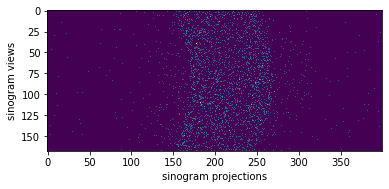

In [211]:
plt.imshow(histogram_4D[tof, mi])
plt.xlabel(labels[3])
plt.ylabel(labels[2])
plt.show()

In [212]:
# compare with file reference
# (assumes the sinogram is not compressed)
sinogram_path = "/".join([phantom_path, filenames[0]])
with open(sinogram_path, 'rb') as file:
    reference_sinogram = np.fromfile(file, dtype=np.uint16)
reference_sinogram = np.reshape(reference_sinogram, shape)

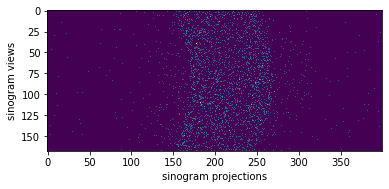

In [213]:
# visual comparison
plt.imshow(reference_sinogram[tof, mi])
plt.xlabel(labels[3])
plt.ylabel(labels[2])
plt.show()

In [214]:
# quantitative comparison
diff = histogram_4D - reference_sinogram
errors = np.sum(np.abs(diff))
if errors == 0:
    print("histogramming successful")

histogramming successful
